In [8]:
import torch
import pprint as pp
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import numpy as np

import matplotlib.pyplot as plt

In [9]:
# hyperparameters

batch_size = 64
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.5

In [10]:
# Create data loaders.

transform = torchvision.transforms.Compose([
              torchvision.transforms.RandomCrop(28, 1),
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize((0.1307,), (0.3081,))
              #torchvision.transforms.RandomRotation(20)
            ])
train_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

test_dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=transform),
  batch_size=batch_size, shuffle=True, drop_last=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [11]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [12]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.predictor = nn.Sequential(
            # N, 1, 28, 28
            nn.Conv2d(1, 8, 3, padding=1, bias=False),
            nn.BatchNorm2d(8), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 14
            
            nn.Conv2d(8, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16), 
            nn.ReLU(True),
            nn.MaxPool2d(2), # 7

            nn.Conv2d(16, 32, 7, padding=0, bias=False),
            nn.BatchNorm2d(32), 
            nn.ReLU(True),
        )

        self.lin = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32, 10),
        )
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(10, 4*49), 
        )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, 3, padding=1, bias=False), # B, 8, 7, 7
            nn.BatchNorm2d(8), 
            nn.ReLU(True),

            nn.ConvTranspose2d(8, 16, 3, stride = 2, padding=1, bias=False, output_padding=1), # B, 16, 14, 14
            nn.BatchNorm2d(16), 
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 16, 3, padding=1, bias=False), # B, 16, 14, 14
            nn.BatchNorm2d(16), 
            nn.ReLU(True),

            nn.ConvTranspose2d(16, 8, 3, padding=1, bias=False), # B, 8, 14, 14
            nn.BatchNorm2d(8), 
            nn.ReLU(True),

            nn.ConvTranspose2d(8, 1, 3, stride = 2, padding=1, bias=False, output_padding=1), # B, 1, 28, 28
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        x = self.predictor(x)
        x = x.mean(-1).mean(-1)
        y = self.lin(x)   

        y_lin = self.decoder_lin(y)
        y_reshaped = torch.reshape(y_lin, (64, 4, 7, 7))
        x_rec = self.decoder(y_reshaped)
        return x_rec, y

model = Autoencoder_conv().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model

Autoencoder_conv(
  (predictor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (lin): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_f

In [15]:

def train(dataloader, model, optimizer, alpha):
    model.train()
    criterion1 = nn.CrossEntropyLoss().to(device)
    criterion2 = nn.MSELoss().to(device)
    for (x, y_true) in dataloader:
        x, y_true = x.to(device), y_true.to(device)
        x_rec, y = model(x)
        x_rec, y = x_rec.to(device), y.to(device)

        class_loss = criterion1(y, y_true) # Calculate classification loss.
        rec_loss = alpha*criterion2(x, x_rec) # Calculate recreation loss.
        loss = class_loss + rec_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'alpha:{alpha}, Loss:{class_loss:.4f}')
    return np.array([class_loss, x, x_rec])


def test(dataloader, model):
    model.eval()
    criterion2 = nn.CrossEntropyLoss().to(device)
    batch_loss = 0
    correct = 0
    with torch.no_grad():
        for (x, y_true) in dataloader:
            x, y_true = x.to(device), y_true.to(device)
            x_rec, y = model(x)
            batch_loss += criterion2(y, y_true) # Only measures classifcation loss.
            pred = y.argmax(dim=1, keepdim=True) 
            correct += pred.eq(y_true.view_as(pred)).sum().item()

    batch_loss /= len(dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          batch_loss, correct, len(dataloader.dataset),
          100. * correct / len(dataloader.dataset)))
    return 100. * correct / len(dataloader.dataset)


In [16]:
alpha_list = np.arange(0, 1.2, 0.2)
alpha_list = [0, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]
alpha_scores = []
recreations = []

for alpha in alpha_list:
    model = Autoencoder_conv().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    epochs = 20
    outputs = []    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        output = train(train_dataloader, model, optimizer, alpha)
        outputs.append(output)
        
    accuracy = test(test_dataloader, model)
    alpha_scores.append(accuracy)    
    recreations.append(output[2]) 
    print("Finished")


Epoch 1
-------------------------------
alpha:0, Loss:0.1872
Epoch 2
-------------------------------
alpha:0, Loss:0.1474
Epoch 3
-------------------------------
alpha:0, Loss:0.0739
Epoch 4
-------------------------------
alpha:0, Loss:0.1549
Epoch 5
-------------------------------
alpha:0, Loss:0.1083
Epoch 6
-------------------------------
alpha:0, Loss:0.5013
Epoch 7
-------------------------------
alpha:0, Loss:0.1340
Epoch 8
-------------------------------
alpha:0, Loss:0.0958
Epoch 9
-------------------------------
alpha:0, Loss:0.1230
Epoch 10
-------------------------------
alpha:0, Loss:0.0900
Epoch 11
-------------------------------
alpha:0, Loss:0.1623
Epoch 12
-------------------------------
alpha:0, Loss:0.0907
Epoch 13
-------------------------------
alpha:0, Loss:0.2020
Epoch 14
-------------------------------
alpha:0, Loss:0.0633
Epoch 15
-------------------------------
alpha:0, Loss:0.1766
Epoch 16
-------------------------------
alpha:0, Loss:0.1842
Epoch 17
--------

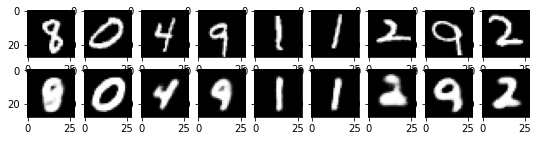

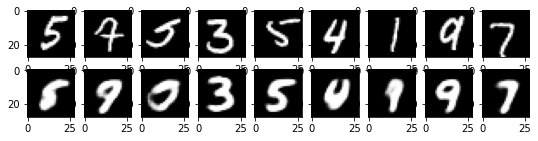

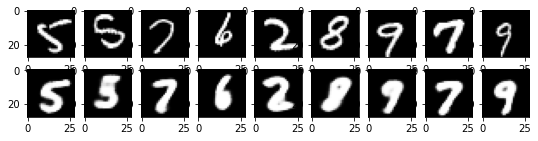

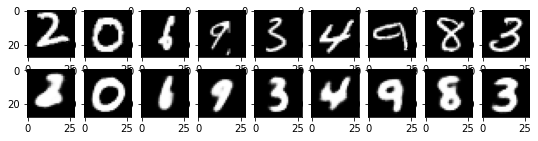

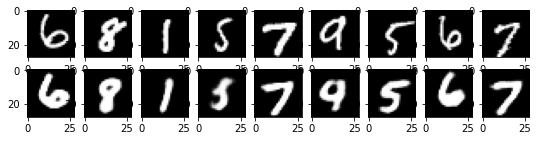

In [17]:
for k in range(0, epochs, 4): 
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().cpu().numpy()
    recon = outputs[k][2].detach().cpu().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2,9, i+1)
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

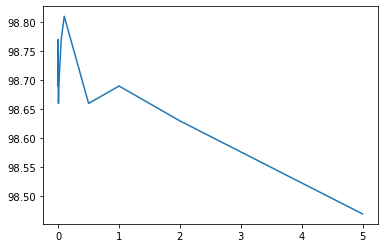

[0, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5]
[98.69, 98.77, 98.72, 98.66, 98.69, 98.77, 98.81, 98.66, 98.69, 98.63, 98.47]


In [19]:
plt.plot(alpha_list, alpha_scores)
plt.show()
print(alpha_list)
print(alpha_scores)